In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd

from silhouette_plot import silhouette_plot
from plot_func import plot_func

In [3]:
import jupyterthemes as jt
jt.jtplot.style(theme = 'grade3', context = 'paper', ticks=True, grid = False)

### Mean Shift Clustering

#### Importing Data

In [4]:
scaled_data = np.load('scaled_traindata.npz', allow_pickle=True, mmap_mode='r')

In [5]:
scaled_data.files

['scaled_data', 'arr_names']

In [6]:
scaled_data.get('arr_names')

array(['pt1', 'eta1', 'phi1', 'sigmaEtaEta1', 'HoverE1', 'isoTrack1',
       'isoEcal1', 'isoHcal1', 'pt2', 'eta2', 'phi2', 'sigmaEtaEta2',
       'HoverE2', 'isoTrack2', 'isoEcal2', 'isoHcal2', 'x0_-1', 'x0_1',
       'x0_EB', 'x0_EE'], dtype=object)

In [7]:
train_data = scaled_data.get('scaled_data')
train_data

array([[0.0553233 , 0.93651436, 0.8267333 , ..., 1.        , 1.        ,
        0.        ],
       [0.04970189, 0.33448867, 0.24761253, ..., 0.        , 1.        ,
        0.        ],
       [0.00426031, 0.36142722, 0.76042529, ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.07373313, 0.67250111, 0.2175304 , ..., 0.        , 0.        ,
        1.        ],
       [0.07313911, 0.43377043, 0.02285605, ..., 0.        , 1.        ,
        0.        ],
       [0.06105568, 0.82186664, 0.31306106, ..., 1.        , 0.        ,
        1.        ]])

In [8]:
train_data.shape

(10000, 24)

#### Clustering method

In [9]:
from sklearn.cluster import MeanShift

##### Without setting bandwidth

In [10]:
mshift = MeanShift(cluster_all=False, n_jobs=3)

In [11]:
mshift_nocat = mshift.fit(train_data[:,:16])

In [12]:
mshift_nocat.get_params()

{'bandwidth': None,
 'bin_seeding': False,
 'cluster_all': False,
 'min_bin_freq': 1,
 'n_jobs': 3,
 'seeds': None}

In [13]:
mshift_nocat.cluster_centers_.shape

(8, 16)

In [14]:
np.unique(mshift_nocat.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7])

In [15]:
predicted_nocat = mshift_nocat.predict(train_data[:,:16])

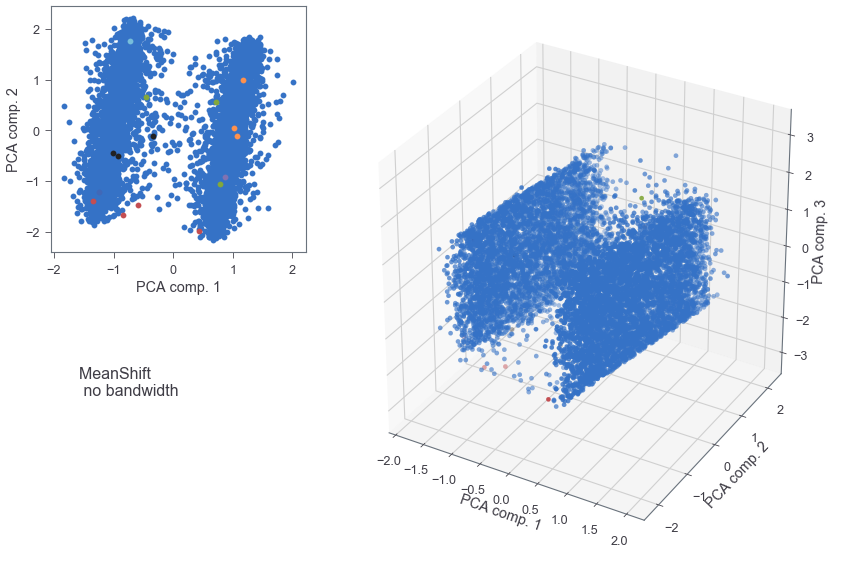

In [16]:
plot_func(data = train_data[:,:16], predicted_values=predicted_nocat, figsize=(12,8), text = 'MeanShift \n no bandwidth')

    * Terrible job

##### Estimating bandwidth

In [145]:
from sklearn.cluster import estimate_bandwidth

In [148]:
bw = estimate_bandwidth(train_data[:,:16], quantile=0.5, n_jobs=3)
bw

0.8255155951758072

In [151]:
mshift = MeanShift(bandwidth=bw, cluster_all=True, n_jobs=3)

In [152]:
mshift_nocat = mshift.fit_predict(train_data[:,:16])

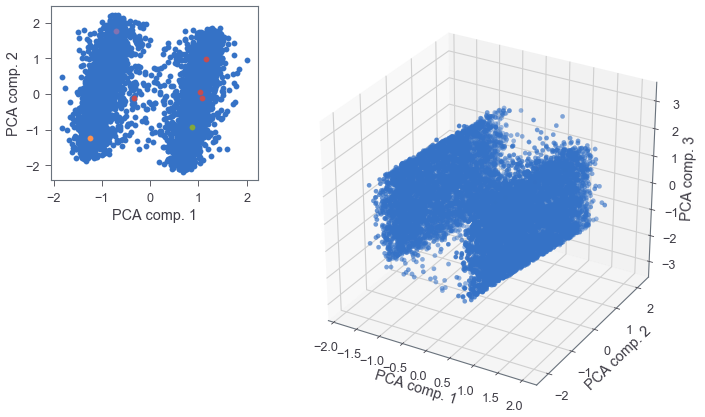

In [153]:
plot_func(train_data[:,:16], mshift_nocat)

In [154]:
# Counts of each cluster
np.unique(mshift_nocat, return_counts=True)

(array([0, 1, 2, 3, 4]), array([9993,    1,    4,    1,    1]))

    * Clearly this bandwidth estimate does not work

##### Bandwidth estimates list by tuning quantiles

In [157]:
bw_list = []

[bw_list.append(estimate_bandwidth(train_data[:,:16], quantile = i, n_jobs=3)) for i in np.arange(0.1, 1, 0.2)]

bw_list 

[0.4470467299883227,
 0.6646202680420004,
 0.8255155951758072,
 0.9332573645275243,
 1.082935596514403]

In [158]:
bw_list.pop(2), bw_list

(0.8255155951758072,
 [0.4470467299883227,
  0.6646202680420004,
  0.9332573645275243,
  1.082935596514403])

##### bw from quantile = 0.1

In [163]:
bw_list[0]

0.4470467299883227

In [160]:
mshift_nocat_bw1 =  MeanShift(bandwidth=bw_list[0], cluster_all=True, n_jobs=3).fit_predict(train_data[:,:16])
np.unique(mshift_nocat_bw1, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 array([4719, 4772,   17,    2,    6,    4,   10,    1,    1,   10,    6,
           1,   57,    1,    2,    4,    3,    1,   79,   49,   44,   15,
           1,    1,  147,    2,    4,   11,    3,    4,    1,   22]))

    * 32 clusters but only 2 are real while all others seem as outliers

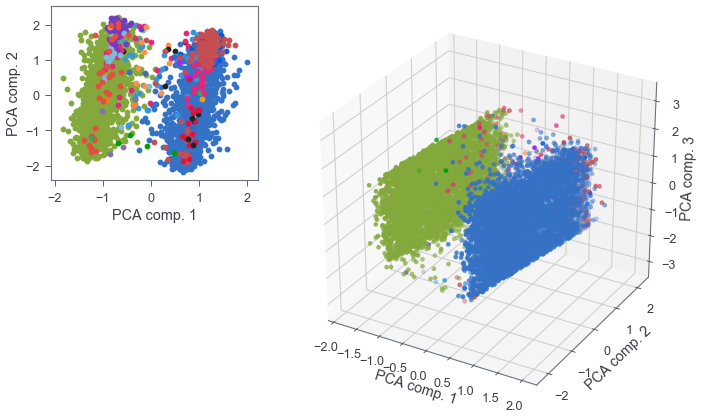

In [161]:
plot_func(train_data[:,:16],mshift_nocat_bw1)

##### Silhouette Analysis

In [298]:
mshift_nocat_bw1[(mshift_nocat_bw1==0) | (mshift_nocat_bw1==1)]

array([1, 0, 0, ..., 0, 0, 0])

In [299]:
silhouette_score(train_data[:,:16][(mshift_nocat_bw1==0) | (mshift_nocat_bw1==1)], 
                 mshift_nocat_bw1[(mshift_nocat_bw1==0) | (mshift_nocat_bw1==1)])

0.3509882828989272

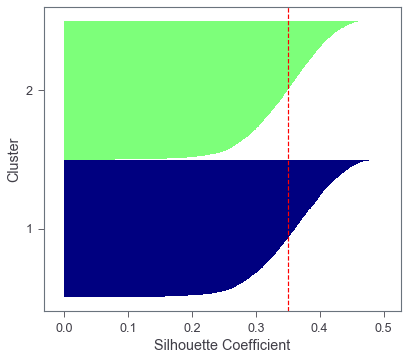

In [300]:
silhouette_plot(train_data[:,:16][(mshift_nocat_bw1==0) | (mshift_nocat_bw1==1)], 
                mshift_nocat_bw1[(mshift_nocat_bw1==0) | (mshift_nocat_bw1==1)])

##### bw from quantile = 0.3

In [162]:
bw_list[1]

0.6646202680420004

In [164]:
mshift_nocat_bw3 =  MeanShift(bandwidth=bw_list[1], cluster_all=True, n_jobs=3).fit_predict(train_data[:,:16])
np.unique(mshift_nocat_bw3, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([9984,    3,    4,    1,    3,    1,    3,    1]))

    * Only 1 real cluster

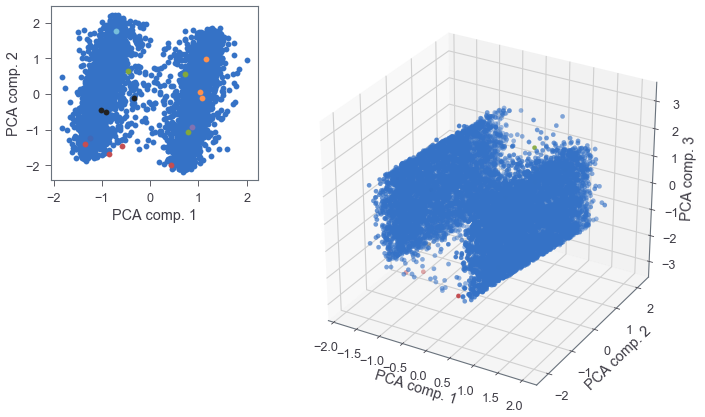

In [165]:
plot_func(train_data[:,:16], mshift_nocat_bw3)

##### bw from quantile = 0.7

In [166]:
bw_list[2]

0.9332573645275243

In [167]:
mshift_nocat_bw7 =  MeanShift(bandwidth=bw_list[2], cluster_all=True, n_jobs=3).fit_predict(train_data[:,:16])
np.unique(mshift_nocat_bw7, return_counts=True)

(array([0, 1]), array([9999,    1]))

    * Similar to above

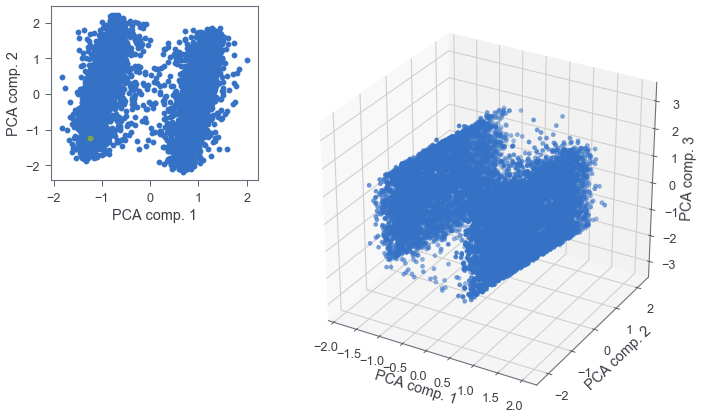

In [168]:
plot_func(train_data[:,:16], mshift_nocat_bw7)

##### bw from quantile = 0.9

In [170]:
bw_list[3]

1.082935596514403

In [171]:
mshift_nocat_bw9 =  MeanShift(bandwidth=bw_list[3], cluster_all=True, n_jobs=3).fit_predict(train_data[:,:16])
np.unique(mshift_nocat_bw9, return_counts=True)

(array([0]), array([10000]))

    * All in one cluster

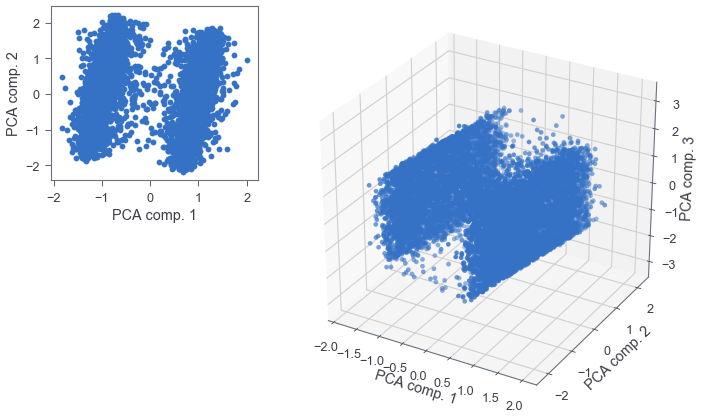

In [172]:
plot_func(train_data[:,:16], mshift_nocat_bw9)

    * So, as in KMeans, we have 2 clusters from MeanShift.
    
    * The MeanShift results are controlled by the bandwidth parameter, in turn determined by the quantile argument.

#### Examining the properties of the clusters

In [174]:
np.unique(mshift_nocat_bw1, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 array([4719, 4772,   17,    2,    6,    4,   10,    1,    1,   10,    6,
           1,   57,    1,    2,    4,    3,    1,   79,   49,   44,   15,
           1,    1,  147,    2,    4,   11,    3,    4,    1,   22]))

    * So cluster 0 and 1 are the main ones

In [180]:
np.unique(train_data[:,16:][mshift_nocat_bw1==0], return_counts=True, axis=0)

(array([[0., 1., 0., 1., 0., 1., 0., 1.],
        [0., 1., 0., 1., 0., 1., 1., 0.],
        [0., 1., 0., 1., 1., 0., 0., 1.],
        [0., 1., 0., 1., 1., 0., 1., 0.],
        [0., 1., 1., 0., 0., 1., 0., 1.],
        [0., 1., 1., 0., 0., 1., 1., 0.],
        [0., 1., 1., 0., 1., 0., 0., 1.],
        [0., 1., 1., 0., 1., 0., 1., 0.],
        [1., 0., 0., 1., 0., 1., 0., 1.],
        [1., 0., 0., 1., 0., 1., 1., 0.],
        [1., 0., 0., 1., 1., 0., 0., 1.],
        [1., 0., 0., 1., 1., 0., 1., 0.],
        [1., 0., 1., 0., 0., 1., 0., 1.],
        [1., 0., 1., 0., 0., 1., 1., 0.],
        [1., 0., 1., 0., 1., 0., 0., 1.],
        [1., 0., 1., 0., 1., 0., 1., 0.]]),
 array([ 56,  80, 149, 257, 186, 189, 478, 976, 204, 179, 454, 980,  60,
         81, 146, 244]))

In [181]:
np.unique(train_data[:,16:][mshift_nocat_bw1==1], return_counts=True, axis=0)

(array([[0., 1., 0., 1., 0., 1., 0., 1.],
        [0., 1., 0., 1., 0., 1., 1., 0.],
        [0., 1., 0., 1., 1., 0., 0., 1.],
        [0., 1., 0., 1., 1., 0., 1., 0.],
        [0., 1., 1., 0., 0., 1., 0., 1.],
        [0., 1., 1., 0., 0., 1., 1., 0.],
        [0., 1., 1., 0., 1., 0., 0., 1.],
        [0., 1., 1., 0., 1., 0., 1., 0.],
        [1., 0., 0., 1., 0., 1., 0., 1.],
        [1., 0., 0., 1., 0., 1., 1., 0.],
        [1., 0., 0., 1., 1., 0., 0., 1.],
        [1., 0., 0., 1., 1., 0., 1., 0.],
        [1., 0., 1., 0., 0., 1., 0., 1.],
        [1., 0., 1., 0., 0., 1., 1., 0.],
        [1., 0., 1., 0., 1., 0., 0., 1.],
        [1., 0., 1., 0., 1., 0., 1., 0.]]),
 array([ 77,  79, 148, 282, 219, 216, 496, 944, 209, 215, 421, 937,  69,
         65, 139, 256]))

##### Ratio of counts

In [192]:
mshift_countsratio = np.unique(train_data[:,16:][mshift_nocat_bw1==0], return_counts=True,  axis=0)[1]/\
np.unique(train_data[:,16:][mshift_nocat_bw1==1], return_counts=True, axis=0)[1]
mshift_countsratio

array([0.72727273, 1.01265823, 1.00675676, 0.91134752, 0.84931507,
       0.875     , 0.96370968, 1.03389831, 0.97607656, 0.83255814,
       1.0783848 , 1.04589114, 0.86956522, 1.24615385, 1.05035971,
       0.953125  ])

In [208]:
import seaborn as sns

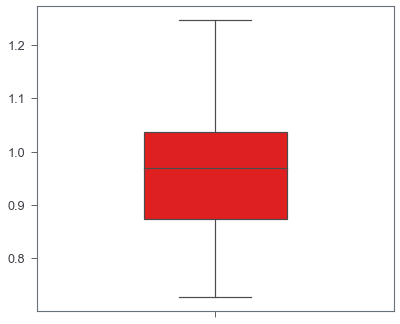

In [212]:
sns.boxplot(mshift_countsratio, orient = 'v', width=0.4, color = 'red' )

    * No outliers, so the clustering, like for KMeans, did not yield results based on the particle charge or type or both.

### DBSCAN

In [213]:
from sklearn.cluster import DBSCAN

    * High dimensions not conducive for DBSCAN but ignored here for the sake of consistency

#### Choosing min_samples

    * A good starting point for min_samples is from the counts from groupby method

In [218]:
groupby_charge_type.ngroup()

0        6
1        8
2        5
3        8
4        9
        ..
9995    10
9996     8
9997     5
9998     8
9999     3
Length: 10000, dtype: int64

In [223]:
np.unique(groupby_charge_type.ngroup(), return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 array([ 523,  327,  154,  170, 1946,  918,  402,  462, 1947, 1028,  417,
         471,  565,  335,  166,  169]))

In [225]:
min_samples = min(np.unique(groupby_charge_type.ngroup(), return_counts=True)[1])
min_samples

154

#### Choosing distance metric for calculating $\epsilon$

    * many available (see sklearn.metrics.pairwise_distances): choosing euclidean

In [226]:
dist_metric = 'euclidean'

    * Since all predictors have been scaled between 0 and 1, using n predictors, max $\epsilon$ should be $\sqrt{n}$.
    
    * Therefore, $\epsilon$ can be anywhere between 0 and $\sqrt{n}$.

In [227]:
# example
from scipy.spatial import distance

In [229]:
distance.euclidean([1,1,1,1,1],[0,0,0,0,0])

2.23606797749979

In [230]:
# 16 predictors, therefore max is 4
eps_search = np.arange(0.25,4.75, 0.75)
eps_search

array([0.25, 1.  , 1.75, 2.5 , 3.25, 4.  ])

#### $\epsilon$ = 0.25

In [247]:
dbscan = DBSCAN(eps = eps_search[0], min_samples=min_samples, metric = dist_metric, n_jobs=3)

In [248]:
dbscan_25 = dbscan.fit(train_data[:,:16])

In [249]:
dbscan_25.core_sample_indices_.shape

(3963,)

In [250]:
np.unique(dbscan_25.labels_, return_counts=True)

(array([-1,  0,  1]), array([1933, 4110, 3957]))

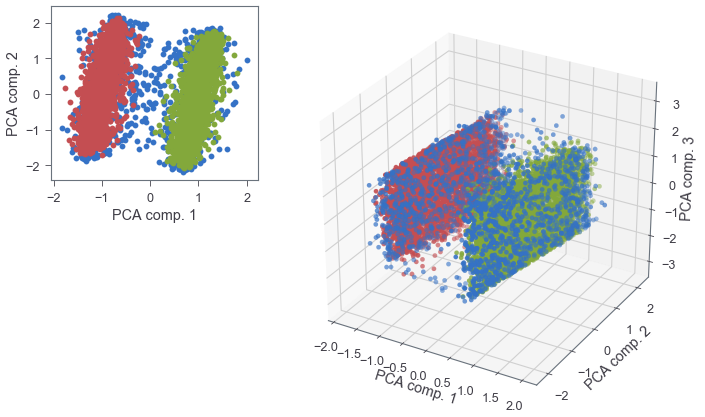

In [251]:
plot_func(train_data[:,:16], dbscan_25.labels_)

#### $\epsilon$ = 1.0

In [244]:
eps_search[1]

1.0

In [252]:
dbscan = DBSCAN(eps = eps_search[1], min_samples=min_samples, metric = dist_metric, n_jobs=3)

In [253]:
dbscan_100 = dbscan.fit(train_data[:,:16])

In [255]:
dbscan_100.core_sample_indices_.shape

(9994,)

In [256]:
np.unique(dbscan_100.labels_, return_counts=True)

(array([0]), array([10000]))

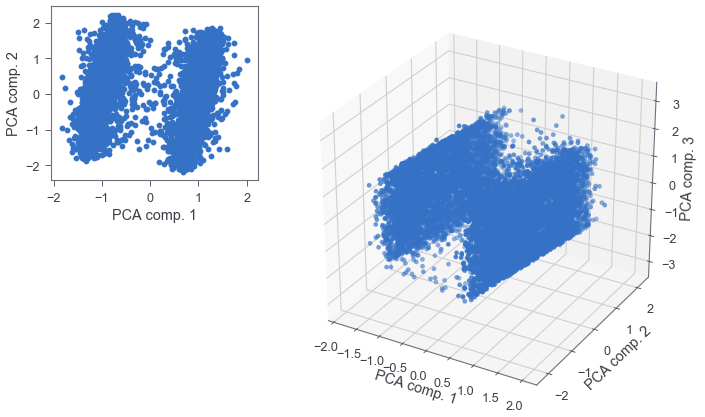

In [257]:
plot_func(train_data[:,:16], dbscan_100.labels_)

    * For $\epsilon$ = 1.0, only 1 cluster, 
    * Implies for values greater than 1.0, the same should be expected. Checking below. 

#### $\epsilon$ = 2.0

In [258]:
eps_search[2]

1.75

In [259]:
dbscan = DBSCAN(eps = eps_search[2], min_samples=min_samples, metric = dist_metric, n_jobs=3)

In [260]:
dbscan_175 = dbscan.fit(train_data[:,:16])

In [261]:
dbscan_175.core_sample_indices_.shape

(10000,)

In [262]:
np.unique(dbscan_175.labels_, return_counts=True)

(array([0]), array([10000]))

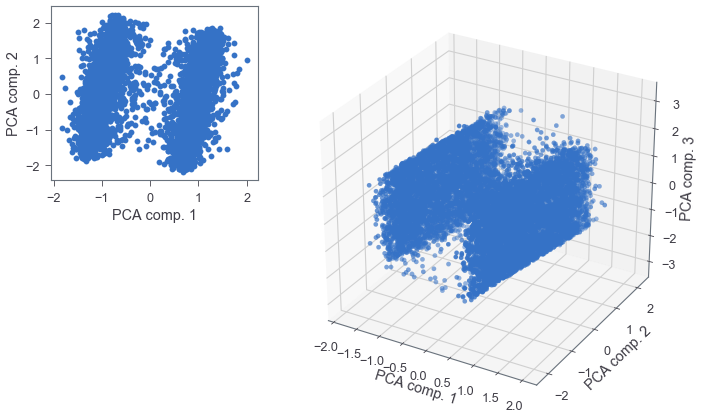

In [263]:
plot_func(train_data[:,:16], dbscan_175.labels_)

    * Confirmed

In [264]:
eps_search

array([0.25, 1.  , 1.75, 2.5 , 3.25, 4.  ])

In [268]:
# new range
np.delete(eps_search, np.s_[1:len(eps_search)])

array([0.25])

In [273]:
eps_search = np.arange(0.3, 0.6, 0.1)

#### $\epsilon$ = 0.3

In [274]:
eps_search[0]

0.3

In [275]:
dbscan = DBSCAN(eps = eps_search[0], min_samples=min_samples, metric = dist_metric, n_jobs=3)

In [277]:
dbscan_30 = dbscan.fit(train_data[:,:16])

In [278]:
dbscan_30.core_sample_indices_.shape

(6666,)

In [279]:
np.unique(dbscan_30.labels_, return_counts=True)

(array([-1,  0,  1]), array([ 551, 4789, 4660]))

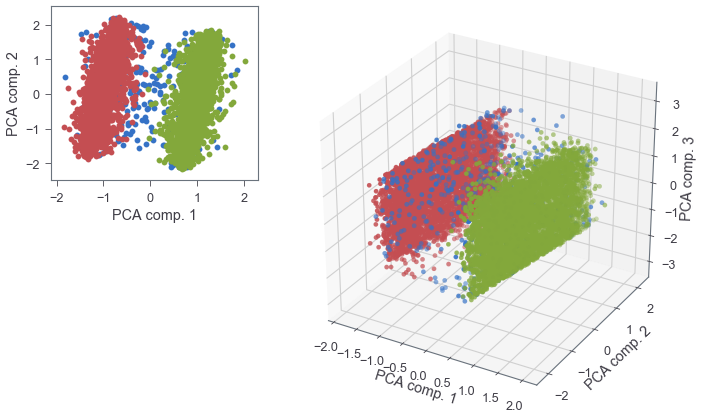

In [280]:
plot_func(train_data[:,:16], dbscan_30.labels_)

    * The blue points are noise or outliers

##### Silhouette Analysis

In [298]:
mshift_nocat_bw1[(mshift_nocat_bw1==0) | (mshift_nocat_bw1==1)]

array([1, 0, 0, ..., 0, 0, 0])

In [301]:
silhouette_score(train_data[:,:16], dbscan_30.labels_)

0.31079135027534704

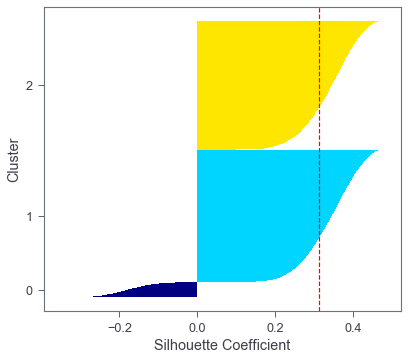

In [302]:
silhouette_plot(train_data[:,:16],dbscan_30.labels_)

#### $\epsilon$ = 0.4

In [281]:
eps_search[1]

0.4

In [282]:
dbscan = DBSCAN(eps = eps_search[1], min_samples=min_samples, metric = dist_metric, n_jobs=3)

In [283]:
dbscan_40 = dbscan.fit(train_data[:,:16])

In [284]:
dbscan_40.core_sample_indices_.shape

(9181,)

In [285]:
np.unique(dbscan_40.labels_, return_counts=True)

(array([-1,  0]), array([  81, 9919]))

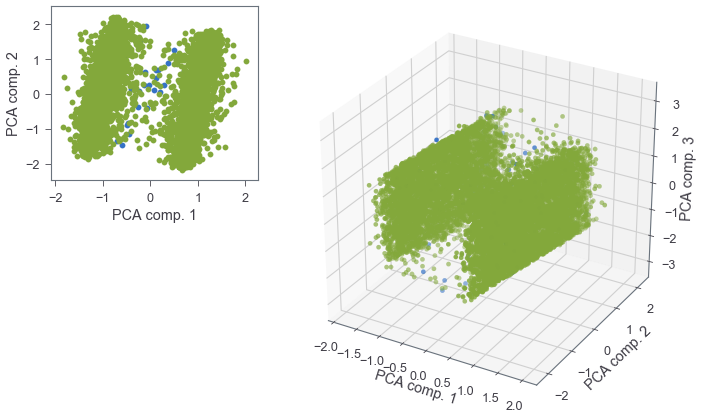

In [286]:
plot_func(train_data[:,:16], dbscan_40.labels_)

    * So, eps = 0.3 is able to resolve the data into clusters and outliers

#### Examining the properties of the clusters

In [303]:
np.unique(dbscan_30.labels_, return_counts=True)

(array([-1,  0,  1]), array([ 551, 4789, 4660]))

    * So cluster 0 and 1 are the main ones, -1 is outliers

In [304]:
np.unique(train_data[:,16:][dbscan_30.labels_==0], return_counts=True, axis=0)

(array([[0., 1., 0., 1., 0., 1., 0., 1.],
        [0., 1., 0., 1., 0., 1., 1., 0.],
        [0., 1., 0., 1., 1., 0., 0., 1.],
        [0., 1., 0., 1., 1., 0., 1., 0.],
        [0., 1., 1., 0., 0., 1., 0., 1.],
        [0., 1., 1., 0., 0., 1., 1., 0.],
        [0., 1., 1., 0., 1., 0., 0., 1.],
        [0., 1., 1., 0., 1., 0., 1., 0.],
        [1., 0., 0., 1., 0., 1., 0., 1.],
        [1., 0., 0., 1., 0., 1., 1., 0.],
        [1., 0., 0., 1., 1., 0., 0., 1.],
        [1., 0., 0., 1., 1., 0., 1., 0.],
        [1., 0., 1., 0., 0., 1., 0., 1.],
        [1., 0., 1., 0., 0., 1., 1., 0.],
        [1., 0., 1., 0., 1., 0., 0., 1.],
        [1., 0., 1., 0., 1., 0., 1., 0.]]),
 array([ 66,  72, 170, 244, 211, 183, 499, 962, 229, 171, 469, 962,  82,
         72, 168, 229]))

In [305]:
np.unique(train_data[:,16:][dbscan_30.labels_==1], return_counts=True, axis=0)

(array([[0., 1., 0., 1., 0., 1., 0., 1.],
        [0., 1., 0., 1., 0., 1., 1., 0.],
        [0., 1., 0., 1., 1., 0., 0., 1.],
        [0., 1., 0., 1., 1., 0., 1., 0.],
        [0., 1., 1., 0., 0., 1., 0., 1.],
        [0., 1., 1., 0., 0., 1., 1., 0.],
        [0., 1., 1., 0., 1., 0., 0., 1.],
        [0., 1., 1., 0., 1., 0., 1., 0.],
        [1., 0., 0., 1., 0., 1., 0., 1.],
        [1., 0., 0., 1., 0., 1., 1., 0.],
        [1., 0., 0., 1., 1., 0., 0., 1.],
        [1., 0., 0., 1., 1., 0., 1., 0.],
        [1., 0., 1., 0., 0., 1., 0., 1.],
        [1., 0., 1., 0., 0., 1., 1., 0.],
        [1., 0., 1., 0., 1., 0., 0., 1.],
        [1., 0., 1., 0., 1., 0., 1., 0.]]),
 array([ 78,  75, 147, 263, 219, 199, 493, 924, 210, 207, 423, 917,  71,
         57, 137, 240]))

In [306]:
np.unique(train_data[:,16:][dbscan_30.labels_==-1], return_counts=True, axis=0)

(array([[0., 1., 0., 1., 0., 1., 0., 1.],
        [0., 1., 0., 1., 0., 1., 1., 0.],
        [0., 1., 0., 1., 1., 0., 0., 1.],
        [0., 1., 0., 1., 1., 0., 1., 0.],
        [0., 1., 1., 0., 0., 1., 0., 1.],
        [0., 1., 1., 0., 0., 1., 1., 0.],
        [0., 1., 1., 0., 1., 0., 0., 1.],
        [0., 1., 1., 0., 1., 0., 1., 0.],
        [1., 0., 0., 1., 0., 1., 0., 1.],
        [1., 0., 0., 1., 0., 1., 1., 0.],
        [1., 0., 0., 1., 1., 0., 0., 1.],
        [1., 0., 0., 1., 1., 0., 1., 0.],
        [1., 0., 1., 0., 0., 1., 0., 1.],
        [1., 0., 1., 0., 0., 1., 1., 0.],
        [1., 0., 1., 0., 1., 0., 0., 1.],
        [1., 0., 1., 0., 1., 0., 1., 0.]]),
 array([25, 19, 18, 58, 41, 35, 36, 61, 23, 24, 26, 67, 17, 25, 22, 54]))

    * Same combination for outliers too

##### Ratio of counts

In [307]:
dbscan_countsratio = np.unique(train_data[:,16:][dbscan_30.labels_==0], return_counts=True,  axis=0)[1]/\
np.unique(train_data[:,16:][dbscan_30.labels_==1], return_counts=True, axis=0)[1]
dbscan_countsratio

array([0.84615385, 0.96      , 1.15646259, 0.92775665, 0.96347032,
       0.91959799, 1.01217039, 1.04112554, 1.09047619, 0.82608696,
       1.10874704, 1.04907306, 1.15492958, 1.26315789, 1.22627737,
       0.95416667])

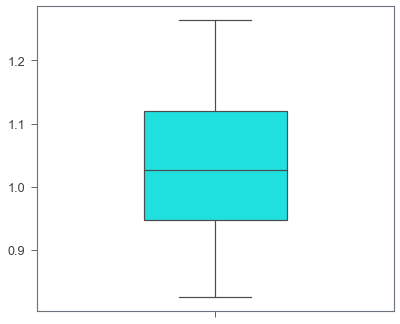

In [308]:
sns.boxplot(dbscan_countsratio, orient = 'v', width=0.4, color = 'cyan' )

    * No outliers, so the clustering did not yield results based on the particle charge or type or both.

### Birch Clustering

In [309]:
from sklearn.cluster import Birch

#### Choosing default parameters

In [310]:
threshold = 0.5
branching_fac = 50

    * Choosing n_clusters from the elbow plot of the KMeans

#### n_clusters = 6

In [311]:
birch = Birch(threshold=threshold, branching_factor=branching_fac, n_clusters=6)

In [312]:
birch_6 = birch.fit(train_data[:,:16])

/home/sameer/datascience/lib/python3.6/site-packages/sklearn/cluster/birch.py:627: ConvergenceWarning: Number of subclusters found (5) by Birch is less than (6). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


In [313]:
birch = Birch(threshold=threshold-0.1, branching_factor=branching_fac, n_clusters=6)
birch_6 = birch.fit(train_data[:,:16])

In [319]:
birch_6.subcluster_labels_, birch_6.subcluster_labels_.shape

(array([1, 5, 2, 2, 1, 5, 2, 2, 5, 1, 4, 1, 1, 2, 3, 2, 2, 5, 0, 3, 1, 1,
        0, 1, 1, 1]), (26,))

In [321]:
np.unique(birch_6.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([   3, 4926, 3625,    7,    1, 1438]))

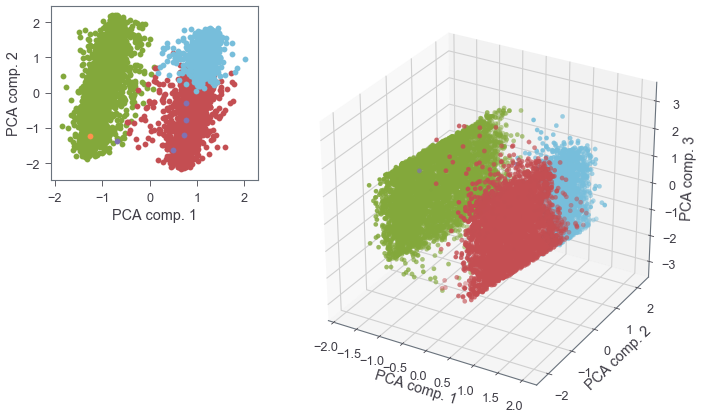

In [320]:
plot_func(train_data[:,:16], birch_6.labels_)

##### Silhouette score for the main clusters

In [335]:
main_ind = np.where((birch_6.labels_==1)|(birch_6.labels_==2)|(birch_6.labels_==5))[0]

In [336]:
silhouette_score(train_data[:,:16][main_ind], birch_6.labels_[main_ind])

0.27331687388294323

##### Examining the properties of the clusters

In [322]:
np.unique(birch_6.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([   3, 4926, 3625,    7,    1, 1438]))

    * So cluster 1, 2 and 5 are the main ones

In [323]:
np.unique(train_data[:,16:][birch_6.labels_==1], return_counts=True, axis=0)

(array([[0., 1., 0., 1., 0., 1., 0., 1.],
        [0., 1., 0., 1., 0., 1., 1., 0.],
        [0., 1., 0., 1., 1., 0., 0., 1.],
        [0., 1., 0., 1., 1., 0., 1., 0.],
        [0., 1., 1., 0., 0., 1., 0., 1.],
        [0., 1., 1., 0., 0., 1., 1., 0.],
        [0., 1., 1., 0., 1., 0., 0., 1.],
        [0., 1., 1., 0., 1., 0., 1., 0.],
        [1., 0., 0., 1., 0., 1., 0., 1.],
        [1., 0., 0., 1., 0., 1., 1., 0.],
        [1., 0., 0., 1., 1., 0., 0., 1.],
        [1., 0., 0., 1., 1., 0., 1., 0.],
        [1., 0., 1., 0., 0., 1., 0., 1.],
        [1., 0., 1., 0., 0., 1., 1., 0.],
        [1., 0., 1., 0., 1., 0., 0., 1.],
        [1., 0., 1., 0., 1., 0., 1., 0.]]),
 array([ 90,  82, 152, 293, 242, 222, 506, 958, 221, 219, 434, 948,  80,
         68, 148, 263]))

In [324]:
np.unique(train_data[:,16:][birch_6.labels_==2], return_counts=True, axis=0)

(array([[0., 1., 0., 1., 0., 1., 0., 1.],
        [0., 1., 0., 1., 0., 1., 1., 0.],
        [0., 1., 0., 1., 1., 0., 0., 1.],
        [0., 1., 0., 1., 1., 0., 1., 0.],
        [0., 1., 1., 0., 0., 1., 0., 1.],
        [0., 1., 1., 0., 0., 1., 1., 0.],
        [0., 1., 1., 0., 1., 0., 0., 1.],
        [0., 1., 1., 0., 1., 0., 1., 0.],
        [1., 0., 0., 1., 0., 1., 0., 1.],
        [1., 0., 0., 1., 0., 1., 1., 0.],
        [1., 0., 0., 1., 1., 0., 0., 1.],
        [1., 0., 0., 1., 1., 0., 1., 0.],
        [1., 0., 1., 0., 0., 1., 0., 1.],
        [1., 0., 1., 0., 0., 1., 1., 0.],
        [1., 0., 1., 0., 1., 0., 0., 1.],
        [1., 0., 1., 0., 1., 0., 1., 0.]]),
 array([ 34,  48, 104, 240,  98, 119, 279, 912, 108,  99, 249, 907,  47,
         46,  96, 239]))

In [325]:
np.unique(train_data[:,16:][birch_6.labels_==5], return_counts=True, axis=0)

(array([[0., 1., 0., 1., 0., 1., 0., 1.],
        [0., 1., 0., 1., 0., 1., 1., 0.],
        [0., 1., 0., 1., 1., 0., 0., 1.],
        [0., 1., 0., 1., 1., 0., 1., 0.],
        [0., 1., 1., 0., 0., 1., 0., 1.],
        [0., 1., 1., 0., 0., 1., 1., 0.],
        [0., 1., 1., 0., 1., 0., 0., 1.],
        [0., 1., 1., 0., 1., 0., 1., 0.],
        [1., 0., 0., 1., 0., 1., 0., 1.],
        [1., 0., 0., 1., 0., 1., 1., 0.],
        [1., 0., 0., 1., 1., 0., 0., 1.],
        [1., 0., 0., 1., 1., 0., 1., 0.],
        [1., 0., 1., 0., 0., 1., 0., 1.],
        [1., 0., 1., 0., 0., 1., 1., 0.],
        [1., 0., 1., 0., 1., 0., 0., 1.],
        [1., 0., 1., 0., 1., 0., 1., 0.]]),
 array([ 45,  36,  78,  29, 130,  75, 241,  75, 133,  84, 235,  90,  43,
         40,  83,  21]))

    * The clustering was not based on the particles charge or type or both.

#### n_clusters = 5

In [326]:
birch = Birch(threshold=threshold, branching_factor=branching_fac, n_clusters=5)

In [327]:
birch_5 = birch.fit(train_data[:,:16])

In [330]:
birch_5.subcluster_labels_

array([3, 4, 2, 1, 0])

In [331]:
np.unique(birch_5.labels_, return_counts=True)

(array([0, 1, 2, 3, 4]), array([1173, 2426, 1970, 2512, 1919]))

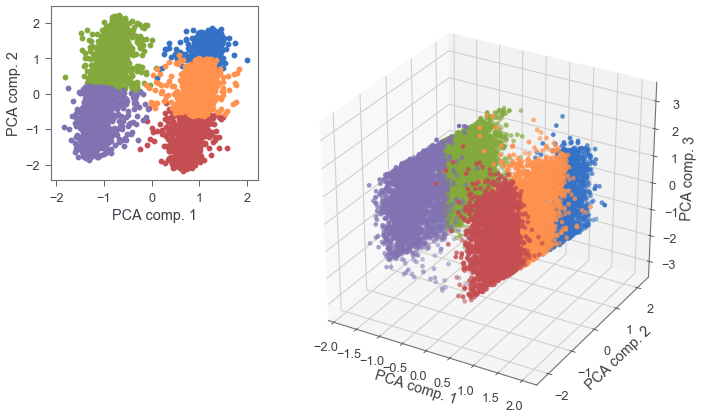

In [332]:
plot_func(train_data[:,:16], birch_5.labels_)

##### Silhouette score for the main clusters

In [337]:
silhouette_score(train_data[:,:16], birch_5.labels_)

0.24156413197360638

    * lower than for 6 clusters

##### Examining the properties of the clusters

In [338]:
np.unique(birch_5.labels_, return_counts=True)

(array([0, 1, 2, 3, 4]), array([1173, 2426, 1970, 2512, 1919]))

In [339]:
np.unique(train_data[:,16:][birch_5.labels_==0], return_counts=True, axis=0)

(array([[0., 1., 0., 1., 0., 1., 0., 1.],
        [0., 1., 0., 1., 0., 1., 1., 0.],
        [0., 1., 0., 1., 1., 0., 0., 1.],
        [0., 1., 0., 1., 1., 0., 1., 0.],
        [0., 1., 1., 0., 0., 1., 0., 1.],
        [0., 1., 1., 0., 0., 1., 1., 0.],
        [0., 1., 1., 0., 1., 0., 0., 1.],
        [0., 1., 1., 0., 1., 0., 1., 0.],
        [1., 0., 0., 1., 0., 1., 0., 1.],
        [1., 0., 0., 1., 0., 1., 1., 0.],
        [1., 0., 0., 1., 1., 0., 0., 1.],
        [1., 0., 0., 1., 1., 0., 1., 0.],
        [1., 0., 1., 0., 0., 1., 0., 1.],
        [1., 0., 1., 0., 0., 1., 1., 0.],
        [1., 0., 1., 0., 1., 0., 0., 1.],
        [1., 0., 1., 0., 1., 0., 1., 0.]]),
 array([ 45,  34,  76,  12, 131,  61, 199,  36, 133,  69, 185,  29,  44,
         36,  68,  15]))

In [340]:
np.unique(train_data[:,16:][birch_5.labels_==1], return_counts=True, axis=0)

(array([[0., 1., 0., 1., 0., 1., 0., 1.],
        [0., 1., 0., 1., 0., 1., 1., 0.],
        [0., 1., 0., 1., 1., 0., 0., 1.],
        [0., 1., 0., 1., 1., 0., 1., 0.],
        [0., 1., 1., 0., 0., 1., 0., 1.],
        [0., 1., 1., 0., 0., 1., 1., 0.],
        [0., 1., 1., 0., 1., 0., 0., 1.],
        [0., 1., 1., 0., 1., 0., 1., 0.],
        [1., 0., 0., 1., 0., 1., 0., 1.],
        [1., 0., 0., 1., 0., 1., 1., 0.],
        [1., 0., 0., 1., 1., 0., 0., 1.],
        [1., 0., 0., 1., 1., 0., 1., 0.],
        [1., 0., 1., 0., 0., 1., 0., 1.],
        [1., 0., 1., 0., 0., 1., 1., 0.],
        [1., 0., 1., 0., 1., 0., 0., 1.],
        [1., 0., 1., 0., 1., 0., 1., 0.]]),
 array([ 46,  34,  72, 150, 109, 112, 237, 471, 114, 104, 219, 487,  45,
         30,  76, 120]))

In [341]:
np.unique(train_data[:,16:][birch_6.labels_==2], return_counts=True, axis=0)

(array([[0., 1., 0., 1., 0., 1., 0., 1.],
        [0., 1., 0., 1., 0., 1., 1., 0.],
        [0., 1., 0., 1., 1., 0., 0., 1.],
        [0., 1., 0., 1., 1., 0., 1., 0.],
        [0., 1., 1., 0., 0., 1., 0., 1.],
        [0., 1., 1., 0., 0., 1., 1., 0.],
        [0., 1., 1., 0., 1., 0., 0., 1.],
        [0., 1., 1., 0., 1., 0., 1., 0.],
        [1., 0., 0., 1., 0., 1., 0., 1.],
        [1., 0., 0., 1., 0., 1., 1., 0.],
        [1., 0., 0., 1., 1., 0., 0., 1.],
        [1., 0., 0., 1., 1., 0., 1., 0.],
        [1., 0., 1., 0., 0., 1., 0., 1.],
        [1., 0., 1., 0., 0., 1., 1., 0.],
        [1., 0., 1., 0., 1., 0., 0., 1.],
        [1., 0., 1., 0., 1., 0., 1., 0.]]),
 array([ 34,  48, 104, 240,  98, 119, 279, 912, 108,  99, 249, 907,  47,
         46,  96, 239]))

In [343]:
np.unique(train_data[:,16:][birch_5.labels_==3], return_counts=True, axis=0)

(array([[0., 1., 0., 1., 0., 1., 0., 1.],
        [0., 1., 0., 1., 0., 1., 1., 0.],
        [0., 1., 0., 1., 1., 0., 0., 1.],
        [0., 1., 0., 1., 1., 0., 1., 0.],
        [0., 1., 1., 0., 0., 1., 0., 1.],
        [0., 1., 1., 0., 0., 1., 1., 0.],
        [0., 1., 1., 0., 1., 0., 0., 1.],
        [0., 1., 1., 0., 1., 0., 1., 0.],
        [1., 0., 0., 1., 0., 1., 0., 1.],
        [1., 0., 0., 1., 0., 1., 1., 0.],
        [1., 0., 0., 1., 1., 0., 0., 1.],
        [1., 0., 0., 1., 1., 0., 1., 0.],
        [1., 0., 1., 0., 0., 1., 0., 1.],
        [1., 0., 1., 0., 0., 1., 1., 0.],
        [1., 0., 1., 0., 1., 0., 0., 1.],
        [1., 0., 1., 0., 1., 0., 1., 0.]]),
 array([ 44,  48,  81, 143, 134, 112, 273, 487, 107, 115, 216, 460,  35,
         38,  74, 145]))

In [344]:
np.unique(train_data[:,16:][birch_5.labels_==4], return_counts=True, axis=0)

(array([[0., 1., 0., 1., 0., 1., 1., 0.],
        [0., 1., 0., 1., 1., 0., 0., 1.],
        [0., 1., 0., 1., 1., 0., 1., 0.],
        [0., 1., 1., 0., 0., 1., 1., 0.],
        [0., 1., 1., 0., 1., 0., 0., 1.],
        [0., 1., 1., 0., 1., 0., 1., 0.],
        [1., 0., 0., 1., 0., 1., 1., 0.],
        [1., 0., 0., 1., 1., 0., 0., 1.],
        [1., 0., 0., 1., 1., 0., 1., 0.],
        [1., 0., 1., 0., 0., 1., 1., 0.],
        [1., 0., 1., 0., 1., 0., 0., 1.],
        [1., 0., 1., 0., 1., 0., 1., 0.]]),
 array([  9,   6, 177,  35,  54, 680,  28,  69, 669,  12,  18, 162]))

    * The last cluster does not have all the charge/type combinations. 

#### n_clusters = 4

In [345]:
birch = Birch(threshold=threshold, branching_factor=branching_fac, n_clusters=4)

In [346]:
birch_4 = birch.fit(train_data[:,:16])

In [347]:
birch_4.subcluster_labels_

array([3, 0, 2, 1, 0])

In [348]:
np.unique(birch_4.labels_, return_counts=True)

(array([0, 1, 2, 3]), array([3092, 2426, 1970, 2512]))

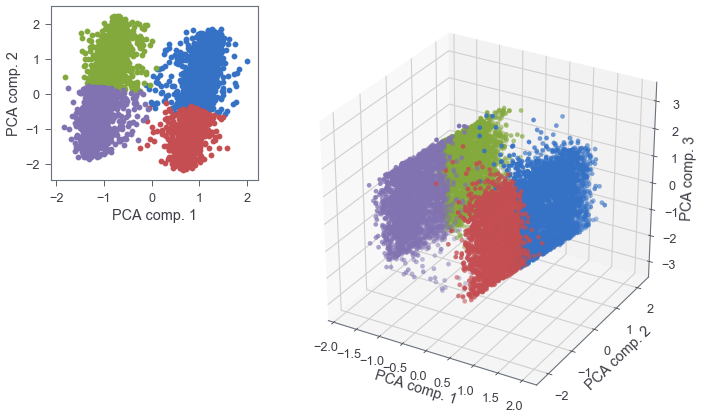

In [349]:
plot_func(train_data[:,:16], birch_4.labels_)

##### Silhouette score for the main clusters

In [350]:
silhouette_score(train_data[:,:16], birch_4.labels_)

0.2856111405386246

    * higher than for 5 and 6 clusters

##### Examining the properties of the clusters

In [351]:
np.unique(birch_4.labels_, return_counts=True)

(array([0, 1, 2, 3]), array([3092, 2426, 1970, 2512]))

In [352]:
np.unique(train_data[:,16:][birch_4.labels_==0], return_counts=True, axis=0)

(array([[0., 1., 0., 1., 0., 1., 0., 1.],
        [0., 1., 0., 1., 0., 1., 1., 0.],
        [0., 1., 0., 1., 1., 0., 0., 1.],
        [0., 1., 0., 1., 1., 0., 1., 0.],
        [0., 1., 1., 0., 0., 1., 0., 1.],
        [0., 1., 1., 0., 0., 1., 1., 0.],
        [0., 1., 1., 0., 1., 0., 0., 1.],
        [0., 1., 1., 0., 1., 0., 1., 0.],
        [1., 0., 0., 1., 0., 1., 0., 1.],
        [1., 0., 0., 1., 0., 1., 1., 0.],
        [1., 0., 0., 1., 1., 0., 0., 1.],
        [1., 0., 0., 1., 1., 0., 1., 0.],
        [1., 0., 1., 0., 0., 1., 0., 1.],
        [1., 0., 1., 0., 0., 1., 1., 0.],
        [1., 0., 1., 0., 1., 0., 0., 1.],
        [1., 0., 1., 0., 1., 0., 1., 0.]]),
 array([ 45,  43,  82, 189, 131,  96, 253, 716, 133,  97, 254, 698,  44,
         48,  86, 177]))

In [353]:
np.unique(train_data[:,16:][birch_4.labels_==1], return_counts=True, axis=0)

(array([[0., 1., 0., 1., 0., 1., 0., 1.],
        [0., 1., 0., 1., 0., 1., 1., 0.],
        [0., 1., 0., 1., 1., 0., 0., 1.],
        [0., 1., 0., 1., 1., 0., 1., 0.],
        [0., 1., 1., 0., 0., 1., 0., 1.],
        [0., 1., 1., 0., 0., 1., 1., 0.],
        [0., 1., 1., 0., 1., 0., 0., 1.],
        [0., 1., 1., 0., 1., 0., 1., 0.],
        [1., 0., 0., 1., 0., 1., 0., 1.],
        [1., 0., 0., 1., 0., 1., 1., 0.],
        [1., 0., 0., 1., 1., 0., 0., 1.],
        [1., 0., 0., 1., 1., 0., 1., 0.],
        [1., 0., 1., 0., 0., 1., 0., 1.],
        [1., 0., 1., 0., 0., 1., 1., 0.],
        [1., 0., 1., 0., 1., 0., 0., 1.],
        [1., 0., 1., 0., 1., 0., 1., 0.]]),
 array([ 46,  34,  72, 150, 109, 112, 237, 471, 114, 104, 219, 487,  45,
         30,  76, 120]))

In [354]:
np.unique(train_data[:,16:][birch_4.labels_==2], return_counts=True, axis=0)

(array([[0., 1., 0., 1., 0., 1., 0., 1.],
        [0., 1., 0., 1., 0., 1., 1., 0.],
        [0., 1., 0., 1., 1., 0., 0., 1.],
        [0., 1., 0., 1., 1., 0., 1., 0.],
        [0., 1., 1., 0., 0., 1., 0., 1.],
        [0., 1., 1., 0., 0., 1., 1., 0.],
        [0., 1., 1., 0., 1., 0., 0., 1.],
        [0., 1., 1., 0., 1., 0., 1., 0.],
        [1., 0., 0., 1., 0., 1., 0., 1.],
        [1., 0., 0., 1., 0., 1., 1., 0.],
        [1., 0., 0., 1., 1., 0., 0., 1.],
        [1., 0., 0., 1., 1., 0., 1., 0.],
        [1., 0., 1., 0., 0., 1., 0., 1.],
        [1., 0., 1., 0., 0., 1., 1., 0.],
        [1., 0., 1., 0., 1., 0., 0., 1.],
        [1., 0., 1., 0., 1., 0., 1., 0.]]),
 array([ 34,  41, 100,  83,  97,  97, 265, 273, 108,  86, 229, 301,  46,
         38,  91,  81]))

In [355]:
np.unique(train_data[:,16:][birch_4.labels_==3], return_counts=True, axis=0)

(array([[0., 1., 0., 1., 0., 1., 0., 1.],
        [0., 1., 0., 1., 0., 1., 1., 0.],
        [0., 1., 0., 1., 1., 0., 0., 1.],
        [0., 1., 0., 1., 1., 0., 1., 0.],
        [0., 1., 1., 0., 0., 1., 0., 1.],
        [0., 1., 1., 0., 0., 1., 1., 0.],
        [0., 1., 1., 0., 1., 0., 0., 1.],
        [0., 1., 1., 0., 1., 0., 1., 0.],
        [1., 0., 0., 1., 0., 1., 0., 1.],
        [1., 0., 0., 1., 0., 1., 1., 0.],
        [1., 0., 0., 1., 1., 0., 0., 1.],
        [1., 0., 0., 1., 1., 0., 1., 0.],
        [1., 0., 1., 0., 0., 1., 0., 1.],
        [1., 0., 1., 0., 0., 1., 1., 0.],
        [1., 0., 1., 0., 1., 0., 0., 1.],
        [1., 0., 1., 0., 1., 0., 1., 0.]]),
 array([ 44,  48,  81, 143, 134, 112, 273, 487, 107, 115, 216, 460,  35,
         38,  74, 145]))

    * All clusters have particles of all types

In [398]:
np.vstack([np.unique(train_data[:,16:][birch_4.labels_==i], return_counts=True, axis=0)[1] for i in range(4)])

array([[ 45,  43,  82, 189, 131,  96, 253, 716, 133,  97, 254, 698,  44,
         48,  86, 177],
       [ 46,  34,  72, 150, 109, 112, 237, 471, 114, 104, 219, 487,  45,
         30,  76, 120],
       [ 34,  41, 100,  83,  97,  97, 265, 273, 108,  86, 229, 301,  46,
         38,  91,  81],
       [ 44,  48,  81, 143, 134, 112, 273, 487, 107, 115, 216, 460,  35,
         38,  74, 145]])

In [401]:
from sklearn.preprocessing import Normalizer

In [404]:
norm=Normalizer().fit_transform(np.vstack([np.unique(train_data[:,16:][birch_4.labels_==i], return_counts=True, axis=0)[1] for i in range(4)]).T)
norm

array([[0.52911891, 0.54087711, 0.39977873, 0.51736071],
       [0.5143158 , 0.40666831, 0.49039414, 0.57411996],
       [0.48599046, 0.42672333, 0.5926713 , 0.48006375],
       [0.64614346, 0.51281227, 0.28375612, 0.48888103],
       [0.55157528, 0.45894432, 0.40841834, 0.56420678],
       [0.45916199, 0.53568898, 0.46394492, 0.53568898],
       [0.49153372, 0.46044858, 0.51484757, 0.53039014],
       [0.70001396, 0.46048404, 0.26690476, 0.47612681],
       [0.57341437, 0.49149804, 0.46562972, 0.46131833],
       [0.47995107, 0.51458672, 0.42552363, 0.56901416],
       [0.55220784, 0.47611621, 0.49785667, 0.46959407],
       [0.68890652, 0.48065541, 0.2970786 , 0.45400716],
       [0.51491052, 0.52661303, 0.53831554, 0.40958791],
       [0.61498042, 0.38436276, 0.4868595 , 0.4868595 ],
       [0.52406884, 0.4631306 , 0.55453796, 0.45094296],
       [0.65369753, 0.44318477, 0.29914972, 0.53551493]])

In [419]:
import pandas as pd

In [420]:
norm_df = pd.DataFrame(data = norm.T, columns=np.arange(0, len(norm)))
norm_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.529119,0.514316,0.485990,0.646143,0.551575,0.459162,0.491534,0.700014,0.573414,0.479951,0.552208,0.688907,0.514911,0.614980,0.524069,0.653698
1,0.540877,0.406668,0.426723,0.512812,0.458944,0.535689,0.460449,0.460484,0.491498,0.514587,0.476116,0.480655,0.526613,0.384363,0.463131,0.443185
2,0.399779,0.490394,0.592671,0.283756,0.408418,0.463945,0.514848,0.266905,0.465630,0.425524,0.497857,0.297079,0.538316,0.486860,0.554538,0.299150
3,0.517361,0.574120,0.480064,0.488881,0.564207,0.535689,0.530390,0.476127,0.461318,0.569014,0.469594,0.454007,0.409588,0.486860,0.450943,0.535515


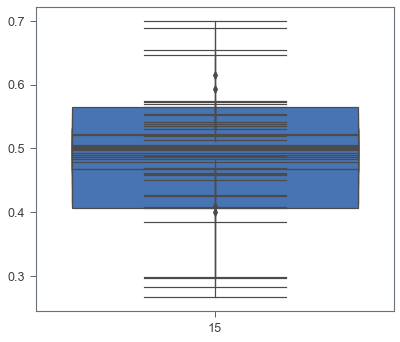

In [418]:
sns.boxplot(x = norm_df.columns, y = norm_df)

In [405]:
np.quantile(norm, 1, axis=1)

array([0.54087711, 0.57411996, 0.5926713 , 0.64614346, 0.56420678,
       0.53568898, 0.53039014, 0.70001396, 0.57341437, 0.56901416,
       0.55220784, 0.68890652, 0.53831554, 0.61498042, 0.55453796,
       0.65369753])

    * Each row corresponds to a combination of q1,q2,type1 and type2. 
    
    * The row with different 

In [399]:
pca = PCA(n_components=2).fit_transform(np.vstack([np.unique(train_data[:,16:][birch_4.labels_==i], return_counts=True, axis=0)[1]
                                                   for i in range(4)]))
pca

array([[ 320.23187189,  -17.36833592],
       [ -11.54185303,   -4.74807962],
       [-294.21388766,  -20.83112875],
       [ -14.47613121,   42.94754429]])

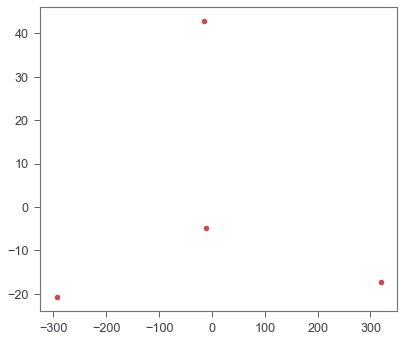

In [400]:
plt.plot(pca[:,0], pca[:,1], 'ro')

    * PCA shows unequal distribution of particle charge/type amongst the clusters.

#### n_clusters = 3

In [356]:
birch = Birch(threshold=threshold, branching_factor=branching_fac, n_clusters=3)

In [357]:
birch_3 = birch.fit(train_data[:,:16])

In [358]:
birch_3.subcluster_labels_

array([0, 1, 2, 0, 1])

In [359]:
np.unique(birch_3.labels_, return_counts=True)

(array([0, 1, 2]), array([4938, 3092, 1970]))

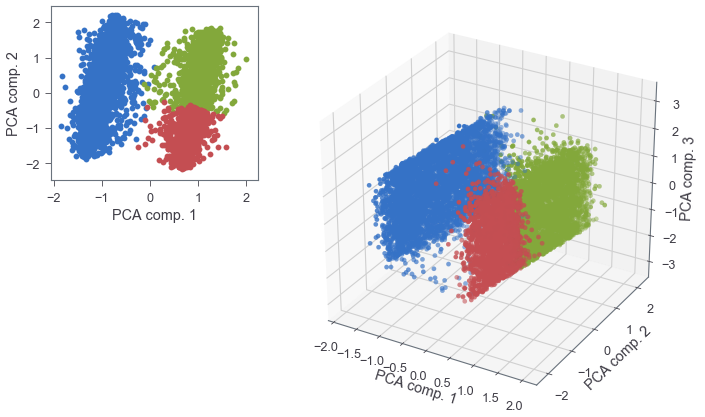

In [360]:
plot_func(train_data[:,:16], birch_3.labels_)

##### Silhouette score for the main clusters

In [361]:
silhouette_score(train_data[:,:16], birch_3.labels_)

0.28259488101433206

    * similar to 4 clusters

##### Examining the properties of the clusters

In [362]:
np.unique(birch_3.labels_, return_counts=True)

(array([0, 1, 2]), array([4938, 3092, 1970]))

In [363]:
np.unique(train_data[:,16:][birch_3.labels_==0], return_counts=True, axis=0)

(array([[0., 1., 0., 1., 0., 1., 0., 1.],
        [0., 1., 0., 1., 0., 1., 1., 0.],
        [0., 1., 0., 1., 1., 0., 0., 1.],
        [0., 1., 0., 1., 1., 0., 1., 0.],
        [0., 1., 1., 0., 0., 1., 0., 1.],
        [0., 1., 1., 0., 0., 1., 1., 0.],
        [0., 1., 1., 0., 1., 0., 0., 1.],
        [0., 1., 1., 0., 1., 0., 1., 0.],
        [1., 0., 0., 1., 0., 1., 0., 1.],
        [1., 0., 0., 1., 0., 1., 1., 0.],
        [1., 0., 0., 1., 1., 0., 0., 1.],
        [1., 0., 0., 1., 1., 0., 1., 0.],
        [1., 0., 1., 0., 0., 1., 0., 1.],
        [1., 0., 1., 0., 0., 1., 1., 0.],
        [1., 0., 1., 0., 1., 0., 0., 1.],
        [1., 0., 1., 0., 1., 0., 1., 0.]]),
 array([ 90,  82, 153, 293, 243, 224, 510, 958, 221, 219, 435, 947,  80,
         68, 150, 265]))

In [364]:
np.unique(train_data[:,16:][birch_3.labels_==1], return_counts=True, axis=0)

(array([[0., 1., 0., 1., 0., 1., 0., 1.],
        [0., 1., 0., 1., 0., 1., 1., 0.],
        [0., 1., 0., 1., 1., 0., 0., 1.],
        [0., 1., 0., 1., 1., 0., 1., 0.],
        [0., 1., 1., 0., 0., 1., 0., 1.],
        [0., 1., 1., 0., 0., 1., 1., 0.],
        [0., 1., 1., 0., 1., 0., 0., 1.],
        [0., 1., 1., 0., 1., 0., 1., 0.],
        [1., 0., 0., 1., 0., 1., 0., 1.],
        [1., 0., 0., 1., 0., 1., 1., 0.],
        [1., 0., 0., 1., 1., 0., 0., 1.],
        [1., 0., 0., 1., 1., 0., 1., 0.],
        [1., 0., 1., 0., 0., 1., 0., 1.],
        [1., 0., 1., 0., 0., 1., 1., 0.],
        [1., 0., 1., 0., 1., 0., 0., 1.],
        [1., 0., 1., 0., 1., 0., 1., 0.]]),
 array([ 45,  43,  82, 189, 131,  96, 253, 716, 133,  97, 254, 698,  44,
         48,  86, 177]))

In [365]:
np.unique(train_data[:,16:][birch_3.labels_==2], return_counts=True, axis=0)

(array([[0., 1., 0., 1., 0., 1., 0., 1.],
        [0., 1., 0., 1., 0., 1., 1., 0.],
        [0., 1., 0., 1., 1., 0., 0., 1.],
        [0., 1., 0., 1., 1., 0., 1., 0.],
        [0., 1., 1., 0., 0., 1., 0., 1.],
        [0., 1., 1., 0., 0., 1., 1., 0.],
        [0., 1., 1., 0., 1., 0., 0., 1.],
        [0., 1., 1., 0., 1., 0., 1., 0.],
        [1., 0., 0., 1., 0., 1., 0., 1.],
        [1., 0., 0., 1., 0., 1., 1., 0.],
        [1., 0., 0., 1., 1., 0., 0., 1.],
        [1., 0., 0., 1., 1., 0., 1., 0.],
        [1., 0., 1., 0., 0., 1., 0., 1.],
        [1., 0., 1., 0., 0., 1., 1., 0.],
        [1., 0., 1., 0., 1., 0., 0., 1.],
        [1., 0., 1., 0., 1., 0., 1., 0.]]),
 array([ 34,  41, 100,  83,  97,  97, 265, 273, 108,  86, 229, 301,  46,
         38,  91,  81]))

In [388]:
np.vstack([np.unique(train_data[:,16:][birch_3.labels_==i], return_counts=True, axis=0)[1] for i in range(3)])

array([[ 90,  82, 153, 293, 243, 224, 510, 958, 221, 219, 435, 947,  80,
         68, 150, 265],
       [ 45,  43,  82, 189, 131,  96, 253, 716, 133,  97, 254, 698,  44,
         48,  86, 177],
       [ 34,  41, 100,  83,  97,  97, 265, 273, 108,  86, 229, 301,  46,
         38,  91,  81]])

In [393]:
pca = PCA(n_components=2).fit_transform(np.vstack([np.unique(train_data[:,16:][birch_3.labels_==i], return_counts=True, axis=0)[1]
                                                   for i in range(3)]))
pca

array([[-523.49850175,  -81.49428612],
       [ -24.41106976,  152.56069723],
       [ 547.9095715 ,  -71.06641111]])

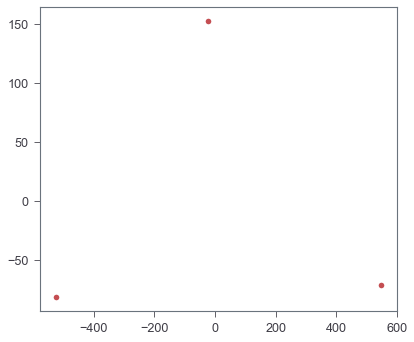

In [392]:
plt.plot(pca[:,0], pca[:,1], 'ro')

    * PCA shows unequal distribution of particle/charge type amongst the clusters.

#### n_clusters = 2

In [366]:
birch = Birch(threshold=threshold, branching_factor=branching_fac, n_clusters=2)

In [367]:
birch_2 = birch.fit(train_data[:,:16])

In [368]:
birch_2.subcluster_labels_

array([1, 0, 0, 1, 0])

In [369]:
np.unique(birch_2.labels_, return_counts=True)

(array([0, 1]), array([5062, 4938]))

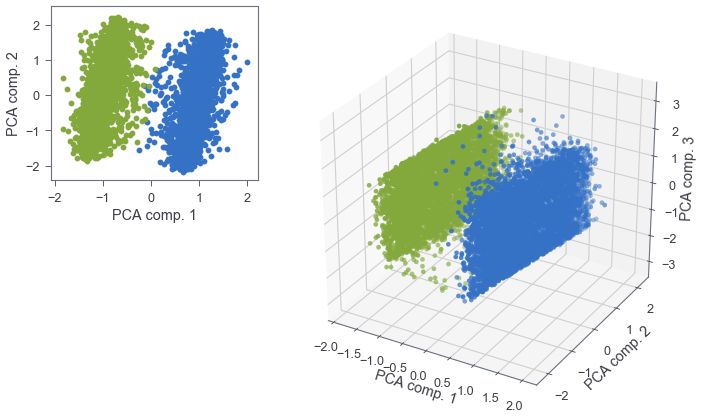

In [370]:
plot_func(train_data[:,:16], birch_2.labels_)

##### Silhouette score for the main clusters

In [371]:
silhouette_score(train_data[:,:16], birch_2.labels_)

0.33747320268060677

    * Highest

##### Examining the properties of the clusters

In [372]:
np.unique(birch_2.labels_, return_counts=True)

(array([0, 1]), array([5062, 4938]))

In [373]:
np.unique(train_data[:,16:][birch_2.labels_==0], return_counts=True, axis=0)

(array([[0., 1., 0., 1., 0., 1., 0., 1.],
        [0., 1., 0., 1., 0., 1., 1., 0.],
        [0., 1., 0., 1., 1., 0., 0., 1.],
        [0., 1., 0., 1., 1., 0., 1., 0.],
        [0., 1., 1., 0., 0., 1., 0., 1.],
        [0., 1., 1., 0., 0., 1., 1., 0.],
        [0., 1., 1., 0., 1., 0., 0., 1.],
        [0., 1., 1., 0., 1., 0., 1., 0.],
        [1., 0., 0., 1., 0., 1., 0., 1.],
        [1., 0., 0., 1., 0., 1., 1., 0.],
        [1., 0., 0., 1., 1., 0., 0., 1.],
        [1., 0., 0., 1., 1., 0., 1., 0.],
        [1., 0., 1., 0., 0., 1., 0., 1.],
        [1., 0., 1., 0., 0., 1., 1., 0.],
        [1., 0., 1., 0., 1., 0., 0., 1.],
        [1., 0., 1., 0., 1., 0., 1., 0.]]),
 array([ 79,  84, 182, 272, 228, 193, 518, 989, 241, 183, 483, 999,  90,
         86, 177, 258]))

In [374]:
np.unique(train_data[:,16:][birch_2.labels_==1], return_counts=True, axis=0)

(array([[0., 1., 0., 1., 0., 1., 0., 1.],
        [0., 1., 0., 1., 0., 1., 1., 0.],
        [0., 1., 0., 1., 1., 0., 0., 1.],
        [0., 1., 0., 1., 1., 0., 1., 0.],
        [0., 1., 1., 0., 0., 1., 0., 1.],
        [0., 1., 1., 0., 0., 1., 1., 0.],
        [0., 1., 1., 0., 1., 0., 0., 1.],
        [0., 1., 1., 0., 1., 0., 1., 0.],
        [1., 0., 0., 1., 0., 1., 0., 1.],
        [1., 0., 0., 1., 0., 1., 1., 0.],
        [1., 0., 0., 1., 1., 0., 0., 1.],
        [1., 0., 0., 1., 1., 0., 1., 0.],
        [1., 0., 1., 0., 0., 1., 0., 1.],
        [1., 0., 1., 0., 0., 1., 1., 0.],
        [1., 0., 1., 0., 1., 0., 0., 1.],
        [1., 0., 1., 0., 1., 0., 1., 0.]]),
 array([ 90,  82, 153, 293, 243, 224, 510, 958, 221, 219, 435, 947,  80,
         68, 150, 265]))

In [395]:
np.vstack([np.unique(train_data[:,16:][birch_2.labels_==i], return_counts=True, axis=0)[1] for i in range(2)])

array([[ 79,  84, 182, 272, 228, 193, 518, 989, 241, 183, 483, 999,  90,
         86, 177, 258],
       [ 90,  82, 153, 293, 243, 224, 510, 958, 221, 219, 435, 947,  80,
         68, 150, 265]])

In [396]:
pca = PCA(2).fit_transform(np.vstack([np.unique(train_data[:,16:][birch_2.labels_==i], return_counts=True, axis=0)[1] for i in range(2)]))
pca

array([[-5.36749476e+01,  7.04007468e-15],
       [ 5.36749476e+01,  7.04007468e-15]])

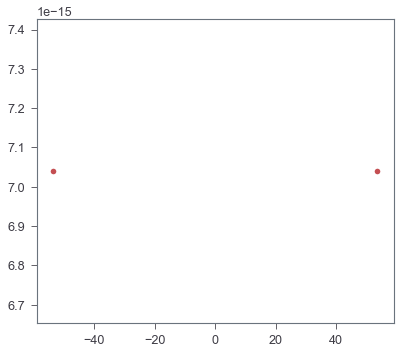

In [397]:
plt.plot(pca[:,0], pca[:,1], 'ro')

    * PCA shows equal distribution of particle charge/type amongst the clusters.

##### Ratio of counts

In [375]:
birch_2_countsratio = np.unique(train_data[:,16:][birch_2.labels_==0], return_counts=True,  axis=0)[1]/\
np.unique(train_data[:,16:][birch_2.labels_==1], return_counts=True, axis=0)[1]
birch_2_countsratio

array([0.87777778, 1.02439024, 1.18954248, 0.92832765, 0.9382716 ,
       0.86160714, 1.01568627, 1.03235908, 1.09049774, 0.83561644,
       1.11034483, 1.05491024, 1.125     , 1.26470588, 1.18      ,
       0.97358491])

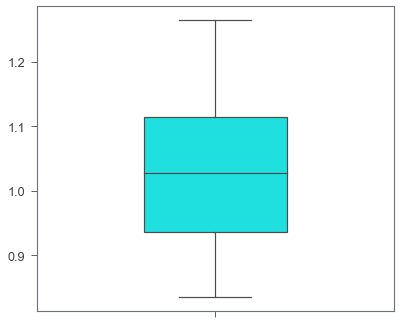

In [376]:
sns.boxplot(birch_2_countsratio, orient = 'v', width=0.4, color = 'cyan' )

    * No outliers, so the clustering did not yield results based on the particle charge or type or both.